# Assignment 3 - Simple analytical model        

__41934 - Advanced BIM, E23__


Kaare G. S. Hansen, s214282 - DTU


## Imports

In [1]:
import os
import sys
import multiprocessing
import importlib
from collections import namedtuple
import numpy as np
import pandas as pd
import ifcopenshell
import ifcopenshell.util.placement
import ifcopenshell.geom
import ifcopenshell.util.shape
import ifcopenshell.util.selector

print(f"ifcopenshell version: {ifcopenshell.version}")
print(f"Python-version {sys.version}")

ifcopenshell version: 0.7.0
Python-version 3.11.6 | packaged by conda-forge | (main, Oct  3 2023, 10:29:11) [MSC v.1935 64 bit (AMD64)]


In [2]:
from OCC.Core.BRepPrimAPI import BRepPrimAPI_MakeBox
from OCC.Core.gp import gp_Pnt, gp_Ax2, gp_Dir, gp_XYZ
from OCC.Core.BRepBndLib import brepbndlib
from OCC.Core.BRepBuilderAPI import BRepBuilderAPI_MakeVertex
from OCC.Core.Bnd import Bnd_OBB
from OCC.Core.BRepTools import breptools_Read
from OCC.Core.TopoDS import TopoDS_Shape, TopoDS_Wire
from OCC.Core.BRep import BRep_Builder
from OCC.Core.GC import GC_MakeArcOfCircle, GC_MakeSegment

from OCC.Display.SimpleGui import init_display
from OCC.Display.OCCViewer import rgb_color

from OCC.Core.gp import gp_Pnt, gp_Dir, gp_Lin
from OCC.Core.Geom import Geom_Line, Geom_Point, Geom_CartesianPoint
from OCC.Core.AIS import AIS_Line, AIS_Point
from OCC.Core.Prs3d import Prs3d_LineAspect, Prs3d_Drawer
from OCC.Core.Quantity import Quantity_Color, Quantity_TOC_RGB
from OCC.Core.Graphic3d import Graphic3d_ZLayerSettings
from OCC.Core.TColStd import TColStd_SequenceOfInteger

import OCC.Core.BRep
import OCC.Core.BRepPrimAPI
import OCC.Core.BRepTools

from OCC.Core.gp import gp_Pnt
from OCC.Core.TopoDS import TopoDS_Vertex
from OCC.Core.BRepBuilderAPI import BRepBuilderAPI_MakeVertex
from OCC.Core.BRep import BRep_Tool
from OCC.Core.TopExp import TopExp_Explorer
from OCC.Core.TColgp import TColgp_Array1OfPnt
from OCC.Core.BRepAdaptor import BRepAdaptor_Curve
from OCC.Core.BRepExtrema import BRepExtrema_DistShapeShape

from OCC.Core.Prs3d import Prs3d_Text
from OCC.Core.Graphic3d import Graphic3d_Group, Graphic3d_Text
from OCC.Core.TCollection import TCollection_AsciiString, TCollection_ExtendedString
from OCC.Core.Quantity import Quantity_Color
from OCC.Core.gp import gp_Pnt
from OCC.Core.Aspect import Aspect_TOL_SOLID
from OCC.Core.AIS import AIS_TextLabel

from OCC.Core.BRepAlgoAPI import BRepAlgoAPI_Common, BRepAlgoAPI_Section, BRepAlgoAPI_BooleanOperation
from OCC.Core.BRepPrimAPI import BRepPrimAPI_MakeWedge
from OCC.Core.gp import gp_Pnt
from OCC.Core.BRepPrimAPI import BRepPrimAPI_MakeBox
from OCC.Core.BRepMesh import BRepMesh_IncrementalMesh
from OCC.Core.BRepExtrema import BRepExtrema_ShapeProximity

In [4]:
from pyconbim.geomUtils import *
from pyconbim.ifcUtils import *
from pyconbim.rendering import *
from pyconbim.analyticalModel import *
import pyconbim.geomUtils
import pyconbim.ifcUtils
import pyconbim.rendering
import pyconbim.utils
import pyconbim.analyticalModel

ModuleNotFoundError: No module named 'pyconbim.ifcUtils'

In [ ]:
importlib.reload(pyconbim.geomUtils)
importlib.reload(pyconbim.ifcUtils)
importlib.reload(pyconbim.rendering)
importlib.reload(pyconbim.utils)
importlib.reload(pyconbim.analyticalModel)
from pyconbim.geomUtils import *
from pyconbim.ifcUtils import *
from pyconbim.rendering import *
from pyconbim.analyticalModel import *

NameError: name 'pyconbim' is not defined

## Load model

In [ ]:
models = load_models(model_dir='/Users/Kaare/My Drive/DTU/Kurser/Videregaaende BIM - 41934/IFC-models\SkyLab',
                     models={#'ark': 'LLYN - ARK.ifc',
                             'stru': 'LLYN - STRU.ifc',
                             })

File path, stru: /Users/Kaare/My Drive/DTU/Kurser/Videregaaende BIM - 41934/IFC-models\SkyLab\LLYN - STRU.ifc
Model schema: IFC4



In [ ]:
model = models['stru']
modelData = ModelData(model)

Beginning processing with 12 threads...
Progress: 0%
Progress: 16%
Progress: 28%
Progress: 43%
Progress: 55%
Progress: 100%
Progress: 100%
Progress: 100%
Processed 3601 items
Contexts: {'Body', 'Axis', 'FootPrint'}


### Group elements

In [ ]:
elements = list(ifcopenshell.util.selector.filter_elements(model,
    "IfcBuildingElement, /Pset_.*Common/.LoadBearing=TRUE"))

elements_loadBearing = {element.GlobalId for element in elements}

elements = list(ifcopenshell.util.selector.filter_elements(model,
    "IfcBuildingElement, /Pset_.*Common/.LoadBearing=FALSE"))

elements_nonloadBearing = {element.GlobalId for element in elements}

elements = model.by_type('IfcBuildingElement')
elements_all = {element.GlobalId for element in elements}

elements = {element.GlobalId: element for element in elements}

print(len(elements_loadBearing))
print(len(elements_nonloadBearing))
print(len(elements_all))

1750
10
1835


In [ ]:
elements_nonloadBearing = elements_all.difference(elements_loadBearing)
print(len(elements_nonloadBearing))

85


In [ ]:
from OCC.Core.BRepOffsetAPI import BRepOffsetAPI_MakePipeShell
from OCC.Core.BRepBuilderAPI import BRepBuilderAPI_MakeEdge, BRepBuilderAPI_MakeWire
from OCC.Core.Geom import Geom_BezierCurve
from OCC.Core.Law import Law_Linear
from OCC.Core.TColgp import TColgp_Array1OfPnt
from OCC.Core.gp import gp_Circ, gp_Pnt, gp_ZOX

In [ ]:
def testRenderFunc(renderer, **args):
    # aModel = args['analyticalModel']
    # Creation of points for the spine
    array = TColgp_Array1OfPnt(1, 5)
    array.SetValue(1, gp_Pnt(1, 4, 0))
    array.SetValue(2, gp_Pnt(2, 2, 0))
    array.SetValue(3, gp_Pnt(3, 3, 0))
    array.SetValue(4, gp_Pnt(4, 3, 0))
    array.SetValue(5, gp_Pnt(5, 5, 0))

    # Creation of a Bezier Curve as the spine
    bz_curv = Geom_BezierCurve(array)
    bz_curv_edge = BRepBuilderAPI_MakeEdge(bz_curv).Edge()
    bz_curv_wire = BRepBuilderAPI_MakeWire(bz_curv_edge).Wire()
    renderer.DisplayShape(bz_curv_wire)

    # Creation of profile to sweep along the spine
    circle = gp_Circ(gp_ZOX(), 1)
    circle.SetLocation(array[0])
    circle_edge = BRepBuilderAPI_MakeEdge(circle).Edge()
    circle_wire = BRepBuilderAPI_MakeWire(circle_edge).Wire()

    # Creation of the law to dictate the evolution of the profile
    brep1 = BRepOffsetAPI_MakePipeShell(bz_curv_wire)
    law_f = Law_Linear()
    law_f.Set(0, 0.5, 1, 1)
    brep1.SetLaw(circle_wire, law_f, False, True)
    
    renderer.DisplayShape(brep1.Shape(), update=True)


INFO:OCC.Display.backend:The pyqt5 backend is already loaded...``load_backend`` can only be called once per session
pyqt5 backend - Qt version 5.15.8


C:\Users\Kaare\AppData\Local\Temp\ipykernel_20256\2797146885.py:18: DeprecationWarning: Call to deprecated function gp_ZOX since pythonocc-core 7.7.1. This function will be removed in a future release, please rather use the static method gp.ZOX
  circle = gp_Circ(gp_ZOX(), 1)
C:\Users\Kaare\AppData\Local\Temp\ipykernel_20256\2797146885.py:18: DeprecationWarning: Call to deprecated function gp_ZOX since pythonocc-core 7.7.1. This function will be removed in a future release, please rather use the static method gp.ZOX
  circle = gp_Circ(gp_ZOX(), 1)


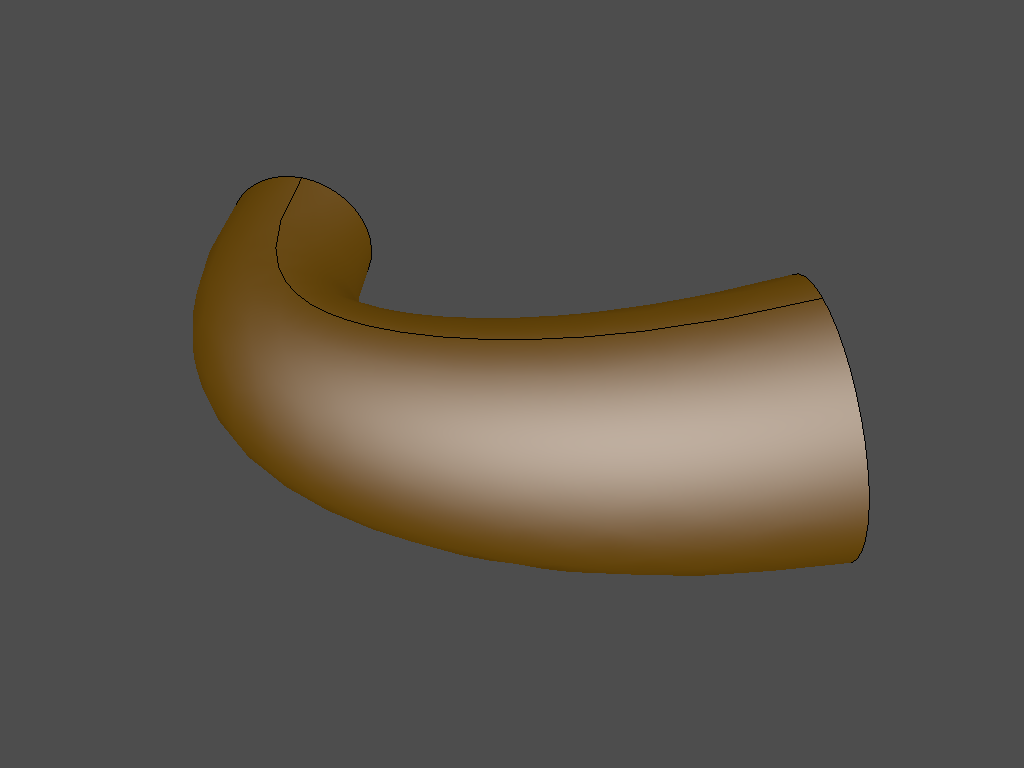

In [ ]:
RenderInWindow(testRenderFunc)
RenderImage(testRenderFunc)

## Make analytical model

**Initial line model based on provided Axis and OBBs**:

In [ ]:
aModel = AnalyticalModel()

for GUID in elements:
    shapes = modelData.shapes[GUID]
    keys = shapes.keys()
    element = modelData.model.by_guid(GUID)
    
    assert 'Body' in keys
    obb = modelData.obbs[GUID]
    body = shapes['Body'].geometry

    
    # Assert that an element doesn't have both Axis and FootPrint
    assert not ('Axis' in keys and 'FootPrint' in keys)

    IfcClass = element.is_a()

    # Beam
    if IfcClass == 'IfcBeam':
        assert 'Axis' in keys

        axis = shapes['Axis'].geometry
        subShapes = get_subShapes(axis)
        assert len(subShapes) == 1
        
        shape = subShapes[0]
        assert is_wire_straight_line(shape)
        wire = shape

        # Axis from ifcopenshell might not even be inside the OBB of the element.
        # Hence not usable at all.
        wire = convert_bnd_to_line(obb, returnWire=True)

        # wire2 = convert_bnd_to_line(obb, returnWire=True)
        # p1a, p2a = geomUtils.get_wire_endpoints(wire)
        # p1b, p2b = geomUtils.get_wire_endpoints(wire2)

        # d1 = np.min([
        #     geomUtils.distance_between_points(p1a, p1b),
        #     geomUtils.distance_between_points(p1a, p2b),
        # ])
        # d2 = np.min([
        #     geomUtils.distance_between_points(p2a, p2b),
        #     geomUtils.distance_between_points(p2a, p1b),
        # ])

        # print(f"d1: {d1}, d2: {d2}")

        member = Beam(GUID, wire)
        # member.wireOBB = wire2

        aModel.addMember(member)
        

    # Column
    elif IfcClass == 'IfcColumn':
        wire = convert_bnd_to_line(obb, returnWire=True)

        member = Column(GUID, wire)
        aModel.addMember(member)

    # Slab
    elif IfcClass == 'IfcSlab':
        # assert 'FootPrint' in keysplaneface = OCC.Core.BRepBuilderAPI.BRepBuilderAPI_MakeFace(plane).Shape()
        plane = geomUtils.convert_bnd_to_plane(obb)
        planeface = OCC.Core.BRepBuilderAPI.BRepBuilderAPI_MakeFace(plane).Shape()
        # Note: commonSurface is taken in the middle of the obb
        commonSurface = BRepAlgoAPI_Common(body, planeface).Shape()
        
        member = Slab(GUID, commonSurface)
        aModel.addMember(member)
        

    # Wall
    elif IfcClass == 'IfcWall':
        pass

    # Plate
    elif IfcClass == 'IfcPlate':
        pass

    else:
        print(f"Unknown class: {IfcClass}")


**Make virtual connections**:

**steps**:

- Find OBB collisions mellem alle beams of columns
- Lav liste med collision-par
- Find closest points for hver axis
- Lav virtual member på ny axis mellem tætteste punkter

In [ ]:
# obbs = {GUID: obbs[GUID] for GUID in elements.keys()}
obbs = {GUID: modelData.obbs[GUID] for GUID in aModel.members.keys()}
print(len(obbs))
common_collisions, element_collisions = find_collisions(obbs)

In [ ]:
collision_pairs = set()

for key, collisions in element_collisions.items():
    for collision in collisions:
        this_key = tuple(sorted([key, collision]))
        collision_pairs.add(this_key)

print(len(collision_pairs))

**Create virtual members**:

In [ ]:
from OCC.Core.BRepExtrema import BRepExtrema_DistShapeShape
def find_closest_points(wire, compound):
            dist = BRepExtrema_DistShapeShape(wire, compound)
            dist.Perform()
            p1 = dist.PointOnShape1(1)
            p2 = dist.PointOnShape2(1)
            return p1, p2

def make_virtual_member(key1, key2, p1, p2):
    distance = geomUtils.distance_between_points(p1, p2)
    
    TOLERANCE = 0.0001
    if distance <= TOLERANCE:
        return None
    try:
        wire = geomUtils.make_wire_from_points([p1, p2])
    except Exception as e:
        print(e)
        print(p1.Coord())
        print(p2.Coord())
        return None
    
    key = ('Virt', key1, key2)
    member = VirtualMember(key=key, axis=wire, member1=key1, member2=key2)
    return member

for collision in collision_pairs:
    key1 = collision[0]
    key2 = collision[1]

    member1 = aModel.members[key1]
    member2 = aModel.members[key2]

    virtualMember = None
    if isinstance(member1, AxialMember) and isinstance(member2, AxialMember):
        wire1 = member1.axis
        wire2 = member2.axis

        p1, p2 = geomUtils.find_closest_points(wire1, wire2)
        virtualMember = make_virtual_member(key1, key2, p1, p2)
        if virtualMember == None:
            continue
    
    # elif ((isinstance(member1, AxialMember) and isinstance(member2, PlanarMember))
    #       or
    #       (isinstance(member2, AxialMember) and isinstance(member1, PlanarMember))):
    #     if isinstance(member1, PlanarMember):
    #         planarMember = member1
    #         axialMember = member2
    #     else:
    #         planarMember = member2
    #         axialMember = member1
        
    #     planarSurface = planarMember.surface
    #     axis = axialMember.axis

    #     p1, p2 = find_closest_points(axis, planarSurface)

    #     continue
    #     # virtualMember = make_virtual_member(key1, key2, p1, p2)
    #     # if not virtualMember:
    #     #     continue
    if virtualMember == None:
        continue
    aModel.addMember(virtualMember)

In [ ]:
aModel.members

### Render analytical model

In [ ]:
def RenderStructuralMembersFunc(renderer, **args):
    modelData = args['modelData']
    aModel = args['analyticalModel']
    members = aModel.members

    RED = Quantity_Color(1.0, 0.0, 0.0, Quantity_TOC_RGB)
    GREEN = Quantity_Color(0.0, 1.0, 0.0, Quantity_TOC_RGB)
    BLUE = Quantity_Color(0.0, 0.0, 1.0, Quantity_TOC_RGB)
    MAGENTA = Quantity_Color(1.0, 0.0, 1.0, Quantity_TOC_RGB)
    BLACK = Quantity_Color(0.0, 0.0, 0.0, Quantity_TOC_RGB)
    GREY = Quantity_Color(0.5, 0.5, 0.5, Quantity_TOC_RGB)

    # Render bodies
    for i,  (GUID, member) in enumerate(members.items()):
        to_update = i % 50 == 0
        try:
            if type(member) in [Beam, Column]:
                body = modelData.shapes[GUID]['Body'].geometry
                renderer.DisplayShape(
                    body,
                    color=GREY,
                    transparency=0.9,
                )
        except Exception as e:
            print(e)


    # Idea: have render code be part of each Structural Members own class
    transparency = 0.8
    color = Quantity_Color(1.0, 0.0, 0.5, Quantity_TOC_RGB)
    for i,  (GUID, member) in enumerate(members.items()):
        to_update = i % 50 == 0

        transparency = 0.8
        try:
            # print(type(member))
            if type(member) == Beam:

                # Render axis
                axis = member.axis
                
                shape = axis
                renderer.DisplayShape(
                    shape,
                    color=color,
                    transparency=transparency,
                    update=to_update,
                )

                # wireOBB = member.wireOBB
                # renderer.DisplayShape(
                #     wireOBB,
                #     color=BLACK,
                #     transparency=transparency,
                # )

                # Render points
                wire = shape

                p1, p2 = geomUtils.get_wire_endpoints(wire)

                renderer.DisplayShape(
                    p1,
                    # color=color,
                )
                renderer.DisplayShape(
                    p2,
                    # color=color,
                )

                # Render label
                obb = modelData.obbs[GUID]
                textLabel = AIS_TextLabel()
                textLabel.SetPosition(gp_Pnt(obb.Center()))
                textLabel.SetText(TCollection_ExtendedString(f"Beam"))
                textLabel.SetColor(color)

                renderer.Context.Display(textLabel, False)

            if type(member) == Column:
                wire = member.axis

                # Render axis
                shape = wire
                renderer.DisplayShape(
                    shape,
                    color=Quantity_Color(0.0, 1.0, 0.5, Quantity_TOC_RGB),
                    transparency=transparency,
                    update=to_update,
                )

                # Render points
                p1, p2 = geomUtils.get_wire_endpoints(wire)

                renderer.DisplayShape(
                    p1,
                    color=BLUE,
                )
                renderer.DisplayShape(
                    p2,
                    color=BLUE,
                )

                # Render label
                obb = modelData.obbs[GUID]
                textLabel = AIS_TextLabel()
                textLabel.SetPosition(gp_Pnt(obb.Center()))
                textLabel.SetText(TCollection_ExtendedString(f"Column"))
                textLabel.SetColor(color)

                renderer.Context.Display(textLabel, False)

            if type(member) == VirtualMember:
                wire = member.axis

                # Render axis
                shape = wire
                renderer.DisplayShape(
                    shape,
                    color=GREEN,
                    transparency=transparency,
                    update=to_update,
                )

                # Render points
                p1, p2 = geomUtils.get_wire_endpoints(wire)

                renderer.DisplayShape(
                    p1,
                    color=MAGENTA,
                )
                renderer.DisplayShape(
                    p2,
                    color=MAGENTA,
                )

            if type(member) == Slab:
                shape = member.surface
                renderer.DisplayShape(
                    shape,
                    color=RED,
                    transparency=0.5,
                    update=to_update,
                )

        except Exception as e:
                print(f"Error! {e}")
                

    renderer.FitAll()

In [ ]:
RenderInWindow(RenderStructuralMembersFunc, modelData=modelData, analyticalModel=aModel)
# RenderImage(RenderStructuralMembersFunc, modelData=modelData, analyticalModel=aModel)

## Convert analytical model to PyNite

In [ ]:
from PyNite import FEModel3D
from PyNite.Visualization import Renderer

In [ ]:
class KeyGenerator:
    def __init__(self):
        self.keys = dict()
        self.counter = 0

    def generate(self, prefix, longKey):
        self.counter += 1
        shortKey = f"{prefix}_{self.counter}"
        self.keys[shortKey] = longKey

        return shortKey

In [ ]:
# Create a new finite element model
model = FEModel3D()
keyGen = KeyGenerator()

# Define a material
E = 29000       # Modulus of elasticity (ksi)
G = 11200       # Shear modulus of elasticity (ksi)
nu = 0.3        # Poisson's ratio
rho = 2.836e-4  # Density (kci)
model.add_material('Steel', E, G, nu, rho)

Y_LOAD = -1.0

for key, member in aModel.members.items():
    if isinstance(member, StructuralMember):
        wire = member.axis
        p1, p2 = geomUtils.get_wire_endpoints(wire)

        N1_key = model.add_node(keyGen.generate('N', ('N', *key, '_1')), p1.X(), p1.Y(), p1.Z())
        N2_key = model.add_node(keyGen.generate('N', ('N', *key, '_2')), p2.X(), p2.Y(), p2.Z())

        # Temporary
        model.def_support(N1_key, True, True, True, True, True, True)
        model.def_support(N2_key, True, True, True, True, True, True)

        M_key = model.add_member(keyGen.generate('M', ('M', key)), N1_key, N2_key, 'Steel', 100, 150, 250, 20)        
        model.add_member_dist_load(M_key, 'Fy', Y_LOAD, Y_LOAD)

        
    elif isinstance(member, VirtualMember):
        wire = member.axis
        p1, p2 = geomUtils.get_wire_endpoints(wire)
        # virt, key1, key2 = key

        N1_key = model.add_node(keyGen.generate('N', ('N', *key, '_1')), p1.X(), p1.Y(), p1.Z())
        N2_key = model.add_node(keyGen.generate('N', ('N', *key, '_2')), p2.X(), p2.Y(), p2.Z())

        # Temporary
        model.def_support(N1_key, True, True, True, True, True, True)
        model.def_support(N2_key, True, True, True, True, True, True)

        M_key = model.add_member(keyGen.generate('M', ('M', key)), N1_key, N2_key, 'Steel', 100, 150, 250, 20)
        model.add_member_dist_load(M_key, 'Fy', Y_LOAD, Y_LOAD)
        
        
    else:
        raise Exception(f"Unknown member type: {type(member)}")
    

# model.analyze()


renderer = Renderer(model)
renderer.annotation_size = 0.05
# renderer.deformed_shape = True
# renderer.deformed_scale = 100
renderer.render_loads = True
renderer.render_model()

**Example**:

In [ ]:
# Example of a simply supported beam with a uniform distributed load.
# Units used in this example are inches and kips
# This example does not use load combinations. The program will create a
# default load combindation called 'Combo 1'

# Import `FEModel3D` from `PyNite`
from PyNite import FEModel3D

# Create a new finite element model
beam = FEModel3D()

# Add nodes (14 ft = 168 inches apart)
beam.add_node('N1', 0, 0, 0)
beam.add_node('N2', 168, 0, 0)

# Define a material
E = 29000       # Modulus of elasticity (ksi)
G = 11200       # Shear modulus of elasticity (ksi)
nu = 0.3        # Poisson's ratio
rho = 2.836e-4  # Density (kci)
beam.add_material('Steel', E, G, nu, rho)

# Add a beam with the following properties:
# Iy = 100 in^4, Iz = 150 in^4, J = 250 in^4, A = 20 in^2
beam.add_member('M1', 'N1', 'N2', 'Steel', 100, 150, 250, 20)

# Provide simple supports
beam.def_support('N1', True, True, True, False, False, False)
beam.def_support('N2', True, True, True, True, False, False)

# Add a uniform load of 200 lbs/ft to the beam (from 0 in to 168 in)
beam.add_member_dist_load('M1', 'Fy', -200/1000/12, -200/1000/12, 0, 168)

# Alternatively the following line would do apply the load to the full
# length of the member as well
# beam.add_member_dist_load('M1', 'Fy', 200/1000/12, 200/1000/12)

# Analyze the beam
beam.analyze()

# # Print the shear, moment, and deflection diagrams
# beam.Members['M1'].plot_shear('Fy')
# beam.Members['M1'].plot_moment('Mz')
# beam.Members['M1'].plot_deflection('dy')

# Print reactions at each end of the beam
print('Left Support Reaction:', beam.Nodes['N1'].RxnFY, 'kip')
print('Right Support Reacton:', beam.Nodes['N2'].RxnFY, 'kip')

# Render the deformed shape of the beam magnified 100 times, with a text
# height of 5 inches
from PyNite.Visualization import Renderer
renderer = Renderer(beam)
renderer.annotation_size = 6
renderer.deformed_shape = True
renderer.deformed_scale = 100
renderer.render_loads = True
renderer.render_model()